This is the original functions from the knapsackWorksheet formatted correctly. Additions to the code follow in the cell right after this one.

In [1]:
def run_knapsack_ga(itemset, max_weight, max_time):
    import time
    import numpy as np
    
    start_time = time.time()
    best_so_far = None    
    while(time.time() - start_time < max_time-0.1):
        from numpy import mean, log
        from matplotlib import pyplot
        import random
        random.seed(100)
        items = itemset
        def get_genotype_value(genotype):
            return sum([items[i].value for i in genotype])
        def get_genotype_weight(genotype):
            return sum([items[i].weight for i in genotype])
        
        def point_mutation(genotype):
            random_genotype_index = random.randint(0, len(genotype)-1)
            current_weight = get_genotype_weight(genotype)
            checked = 0
            while(True):
                random_item_index = random.randint(0, num_items-1)
                weight_with_random = current_weight + items[random_item_index].weight - items[random_genotype_index].weight
                if random_item_index not in genotype and weight_with_random <= max_weight:
                    genotype[random_genotype_index] = random_item_index
                    return genotype
                if checked > num_items:
                    return genotype
                
        def mutate_genotype(genotype, prob_mut=0.5):
            mutated_genotype = genotype[:]
            if random.random() < prob_mut:
                point_mutation(mutated_genotype)
            return mutated_genotype
        
        def get_genotype_fitness(genotype):
            if get_genotype_weight(genotype) > max_weight or (get_genotype_weight(genotype)) == 0:
                return 0
            else:
                return get_genotype_value(genotype)/(get_genotype_weight(genotype)/max_weight)
            
        def get_best_from_population(pop):
            values = [get_genotype_value(gene) for gene in pop]
            return values.index(max(values))
        
        def random_individual():
            total_weight = 0

            #This is a list of the indexes from the item list
            #the individual has in its knapsack
            org_genotype = []

            while(total_weight < max_weight):
                random_item_index = random.randint(0, num_items-1)

                #Make sure this item isn't already in our knapsack.
                if random_item_index not in org_genotype:

                    #But if this item would break our knapsack, 
                    #lets just go ahead and call this organism done.
                    if total_weight + itemset[random_item_index].weight > max_weight:
                        return org_genotype

                    #Otherwise we can add this item and keep going!
                    else:
                        org_genotype.append(random_item_index)
                        total_weight += itemset[random_item_index].weight

            return org_genotype
        def knapsack(best_so_far, pop_size = 1000, num_generations = 1000, get_next_gen = "random"):
            pop_size = 1000
            num_generations = 1000

            population = [random_individual() for _ in range(pop_size)]
            pop_fitness = [get_genotype_fitness(g) for g in population]

            #keep track of mean fitness over time
            mean_fitnesses = [mean(pop_fitness)]

            #also keep track of the mean value of knapsacks overtime
            mean_value = mean([get_genotype_value(ind) for ind in population])
            mean_values = [mean_value]

            for generation in range(num_generations):
                pop_fitness = [get_genotype_fitness(g) for g in population]
                population = random.choices(population, k=pop_size, weights=pop_fitness)
                population = [mutate_genotype(g, prob_mut = 0.01) for g in population]

                #record new mean population fitness and knapsack values
                mean_fitnesses.append(mean(pop_fitness))
                mean_values.append(mean([get_genotype_value(ind) for ind in population]))

            #After evolving solutions, plot some figures
            pyplot.figure()
            pyplot.plot(mean_values)
            pyplot.xlabel("Generation")
            pyplot.ylabel("Mean Knapsack Value")
            pyplot.show()

            pyplot.figure()
            pyplot.plot(mean_fitnesses)
            pyplot.xlabel("Generation")
            pyplot.ylabel("Mean Population Fitness")
            pyplot.show()
            return population[get_best_from_population(population)]
        
        best_so_far = knapsack(best_so_far)
        return best_so_far

Just some declarations to create an itemset to study, analyze the solutions outside of the function

In [2]:
import random
def get_genotype_value(genotype):
            return sum([itemset[i].value for i in genotype])
def get_genotype_weight(genotype):
            return sum([itemset[i].weight for i in genotype])
def get_genotype_fitness(genotype):
            if get_genotype_weight(genotype) > max_weight or (get_genotype_weight(genotype)) == 0:
                return 0
            else:
                return get_genotype_value(genotype)/(get_genotype_weight(genotype)/max_weight)
class Item:
            def __init__(self, weight, value):
                self.weight = weight
                self.value = value

            def __repr__(self):
                return "Item value: {0}, weight: {1}".format(self.value, self.weight)

This analyzes a random data set of population size 1000 and over a 1000 generations, with a 1% chance of mutation every generation. It visualizes the mean knapsack value accross generations, the mean population fitness and the then some details about the final knapsack.

In [3]:
pop_size = 1000
num_items = 1000
random.seed(9999)
itemset = [Item(random.randint(10, 100), random.randint(10, 100)) for _ in range(num_items)]
max_weight = 200
# max_time = 10
# best = run_knapsack_ga(itemset, max_weight, max_time)
# result = ("Final Knapsack \n Its contents are {0} \n its value is {1}, weight is {2} and fitness is {3}").format(best, 
#                                                                        get_genotype_value(best),
#                                                                       get_genotype_weight(best),
#                                                                       get_genotype_fitness(best))
# print(result)

### Extensions
The extended run_knapsack_ga below implements the follwing extended helper functions:
    - point_mutation_better, which only mutates a knapsack iff it can find a better one while searching the population
    pop_size times.
    - get_best_from_population, which returs the fittest knapsack in the current population
    - split_list, which splits a knapsack list in half
    - join_list, which creates a new knapsack by taking the first list and appending to it elements from the second list as long as they will fit in the knapsack.
    - recombination, which sorts the two given knapsacks by the item index, and joins them using join_list with the more valuable knapsack as list 1
    - better_recombination, which sorts the two given knapsacks by the value of the items inside, the calls join_list with the more fit knapsack as list 1.
    - tournament_selection, which takes in a population, and a k number of enteries. It them selects k knapsacks, pits them against each other and selects the one with the highest fitness. It then replicates that one onto the population, also using better_mutation to mutate it, and making sure the population doesn't become stagnant.
    - rank_order_selection: Which takes in a population and a scaling factor. It then constructs a scaled fitness value for each knapsack which it then uses to create another population, which it returns. 

The following implementation uses the following methods in order,
    - random
    - recombination, using the recombination function above on a random number between 1 and pop_size/2 of individuals in the population.
    - better_recombination, same as recombination but using the 'better_recombination' function.
    - tournament_selection, using the tournament_selection funciton above on the population between 1 and pop_size/5 times population and k(the number of enterants in the competition) between 1 and 5.
    - rank_order_selection, calls the rank_order_selection function with a fitness scaling value between 0.001 and 1.0 
    - elitism, for half the number of generations keeps track of the best function, and then in the other half it uses those 'elite' knapsacks to further populate the space.
The function runs these in order on a random population, it then prints out the best knap_sack generated by each method, in order. Currently it works using the modified population from the previous method, but it is trivial to implement an iteration where it uses the same knapsack along populations by making a copy of the original knapsack when created.

In [4]:
def run_knapsack_ga(itemset, max_weight, max_time):
    import time
    import numpy as np
    
    start_time = time.time()
    best_so_far = None
    
    while(time.time() - start_time < max_time-0.1):
        from numpy import mean, log
        from matplotlib import pyplot
        import random
        random.seed(100)
        items = itemset
        def get_genotype_value(genotype):
            return sum([items[i].value for i in genotype])
        def get_genotype_weight(genotype):
            return sum([items[i].weight for i in genotype])
        
        def point_mutation(genotype):
            random_genotype_index = random.randint(0, len(genotype)-1)
            current_weight = get_genotype_weight(genotype)
            checked = 0
            while(True):
                random_item_index = random.randint(0, num_items-1)
                weight_with_random = current_weight + items[random_item_index].weight - items[random_genotype_index].weight
                if random_item_index not in genotype and weight_with_random <= max_weight:
                    genotype[random_genotype_index] = random_item_index
                    return genotype
                if checked > num_items:
                    return genotype
                
        def mutate_genotype(genotype, prob_mut=0.5, type_mutation = "better"):
            mutated_genotype = genotype[:]
            if random.random() < prob_mut:
                if type_mutation == "better":
                    point_mutation_better(mutated_genotype)
                else:
                    point_mutation(mutated_genotype)
            return mutated_genotype
        
        def point_mutation_better(genotype):
            current_weight = get_genotype_weight(genotype)
            current_value =  get_genotype_value(genotype)
            random_genotype_index = random.randint(0, len(genotype)-1)
            checked = 0
            while(True):
                random_item_index = random.randint(0, num_items-1)
                weight_with_random = current_weight + items[random_item_index].weight - items[genotype[random_genotype_index]].weight
                value_with_random = current_value + items[random_item_index].value - items[genotype[random_genotype_index]].value
                checked = checked+1
                if random_item_index not in genotype and weight_with_random <= max_weight and value_with_random > current_value:
                    genotype[random_genotype_index] = random_item_index
                    assert(get_genotype_value(genotype) > current_value)
                    return genotype
                if checked > num_items:
                    assert(get_genotype_value(genotype) >= current_value)
                    return genotype
                
        def get_genotype_fitness(genotype):
            if get_genotype_weight(genotype) > max_weight or (get_genotype_weight(genotype)) == 0:
                return 0
            else:
                return get_genotype_value(genotype)/(get_genotype_weight(genotype))
            
        def get_best_from_population(pop):
            values = [get_genotype_value(gene) for gene in pop]
            return values.index(max(values))
        
        def split_list(gene):
            in_half = int(len(gene)/2)
            return gene[:in_half], gene[in_half:]
        
        def add_list(list1, list2):
            current_weight = get_genotype_weight(list1)
            for item in list2:
                with_item = current_weight + items[item].weight
                if item not in list1 and with_item <= max_weight:
                    list1.append(item)
                    current_weight = with_item
            return list1
        
        def recombination(genotype1, genotype2):
            # Arrange them in increasing order to prevent conflicts. 
            genotype1.sort()
            genotype2.sort()
            genotype1part1, genotype1part2 = split_list(genotype1)
            genotype2part1, genotype2part2 = split_list(genotype2)
            genotype1 = add_list(genotype1part1, genotype2part2)
            genotype2 = add_list(genotype2part1, genotype1part2)
            return genotype1, genotype2
        
        def better_recombination(genotype1, genotype2):
            sorted(genotype1, key = lambda x:itemset[x].value)
            sorted(genotype2, key = lambda x:itemset[x].value)
            genotype1part1, genotype1part2 = split_list(genotype1)
            genotype2part1, genotype2part2 = split_list(genotype2)
            if (get_genotype_value(genotype1part2) > get_genotype_value(genotype2part2)):
                genotype1 = add_list(genotype1part2, genotype2part2)
            else:
                genotype1 = add_list(genotype2part2, genotype1part2)
            genotype2 = point_mutation(genotype1)
            return genotype1, genotype2
        
        def random_individual():
            total_weight = 0

            #This is a list of the indexes from the item list
            #the individual has in its knapsack
            org_genotype = []

            while(total_weight < max_weight):
                random_item_index = random.randint(0, num_items-1)

                #Make sure this item isn't already in our knapsack.
                if random_item_index not in org_genotype:

                    #But if this item would break our knapsack, 
                    #lets just go ahead and call this organism done.
                    if total_weight + items[random_item_index].weight > max_weight:
                        return org_genotype

                    #Otherwise we can add this item and keep going!
                    else:
                        org_genotype.append(random_item_index)
                        total_weight += items[random_item_index].weight

            return org_genotype
        
        def tournament_selection(population, k):
            items_match = random.sample(range(0, len(population)), k)
            to_reproduce = sorted(items_match, key = lambda x:get_genotype_value(population[x]))[-1]
            for item in items_match:
                population[item] = mutate_genotype(population[to_reproduce], 0.001)
            return population
        
        def rank_order_selection(population, factor):
            population = sorted(population, key = lambda x:get_genotype_value(x))
            scaled_fitness = [(factor**float(len(population)-g))*(factor-1)/(factor**float(len(population))-1) for g in range(len(population))]
            population = random.choices(population, k=pop_size, weights=scaled_fitness)
            return population

        def fitness_equalizer(population):
            return
        
        def knapsack(best_so_far, pop_size = 1000, num_generations = 1000, get_next_gen = "random"):
            pop_size = 1000
            num_generations = 1000

            population = [random_individual() for _ in range(pop_size)]
            pop_fitness = [get_genotype_fitness(g) for g in population]

            #keep track of mean fitness over time
            mean_fitnesses = [mean(pop_fitness)]

            #also keep track of the mean value of knapsacks overtime
            mean_value = mean([get_genotype_value(ind) for ind in population])
            mean_values = [mean_value]
            elites = []
            generation = 0
            while(generation < num_generations and time.time() - start_time < max_time-0.1):
                generation+=1
                pop_fitness = [get_genotype_fitness(g) for g in population]
                prev_pop = population[:]
                if get_next_gen is "random":
                    population = random.choices(population, k=pop_size, weights=pop_fitness)
                elif get_next_gen is "recombination":
                    i = random.randint(1, pop_size/2)
                    while(i):
                        i-=1
                        first, second = random.sample(range(0, len(population)-1), 2)
                        population[first], population[second] = recombination(population[first], population[second])
                elif get_next_gen is "better_recombination":
                    i = random.randint(1, pop_size/2)
                    while(i):
                        i-=1
                        first, second = random.sample(range(0, len(population)-1), 2)
                        population[first], population[second] = better_recombination(population[first], population[second])
                elif get_next_gen is "proportional":
                    population = random.choices(population, k=pop_size, weights=pop_fitness)
                elif get_next_gen is "tournament_selection":
                    population = tournament_selection(population, random.randint(1, 1+pop_size%3))
                elif get_next_gen is "rank_order_selection":
                    population = rank_order_selection(population, random.uniform(0.001, 1.0))
                elif get_next_gen is "elitism":
                    next_elite = population[get_best_from_population(population)]
                    if next_elite not in elites:
                        elites.append(next_elite)
                    if generation <= num_generations/2:
                        population = random.choices(population, k=pop_size, weights=pop_fitness)
                    else:
                        elites_fitness = [get_genotype_fitness(g) for g in elites]
                        population = random.choices(elites, k=pop_size, weights=elites_fitness)
                        population = [mutate_genotype(g, prob_mut = 0.1) for g in population]
                    
                if best_so_far:
                    best_so_far = max(best_so_far, population[get_best_from_population(population)], key = lambda x:get_genotype_value(x))
                else:
                    best_so_far = population[get_best_from_population(population)]
                    
                #record new mean population fitness and knapsack values
                population = [mutate_genotype(g, prob_mut = 0.001) for g in population]
                mean_fitnesses.append(mean(pop_fitness))
                mean_values.append(mean([get_genotype_value(ind) for ind in population]))

            #After evolving solutions, plot some figures
            pyplot.figure()
            pyplot.plot(mean_values)
            pyplot.xlabel("Generation")
            pyplot.ylabel("Mean Knapsack Value")
            pyplot.show()

            pyplot.figure()
            pyplot.plot(mean_fitnesses)
            pyplot.xlabel("Generation")
            pyplot.ylabel("Mean Population Fitness")
            pyplot.show()
            return best_so_far
        
        best_so_far = [0]
        types = ["rank_order_selection", "elitism", "tournament_selection", "random", "proportional"]
        for kind in types:
            best_so_far = max(knapsack(best_so_far, get_next_gen = kind), best_so_far, key = lambda x:get_genotype_value(x))
            print("Best from {0} is {1} whose weight is {2}, value is {3} and fitness is {4}".
                  format(kind,
                         best_so_far,
                         get_genotype_weight(best_so_far),
                         get_genotype_value(best_so_far),
                         get_genotype_fitness(best_so_far)))
        return best_so_far

In [5]:
# Remember to execute the cell above this to get the final version of the program.
max_time = 40
max_weight = 200

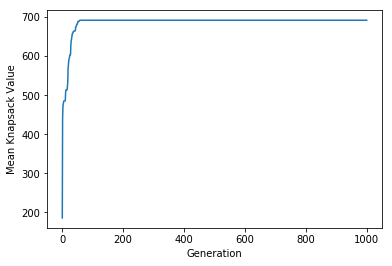

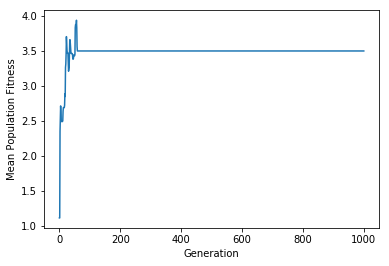

Best from rank_order_selection is [391, 244, 933, 608, 374, 473, 580] whose weight is 198, value is 692 and fitness is 3.494949494949495


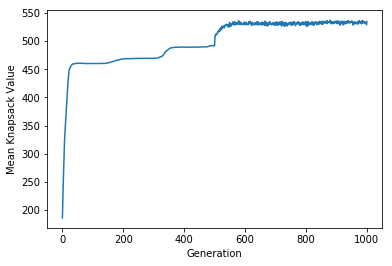

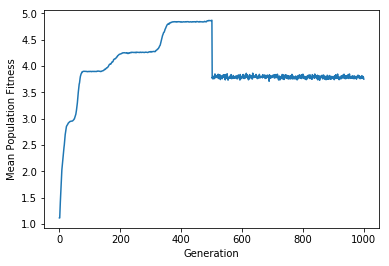

Best from elitism is [244, 391, 167, 608, 386, 374, 580] whose weight is 200, value is 693 and fitness is 3.465


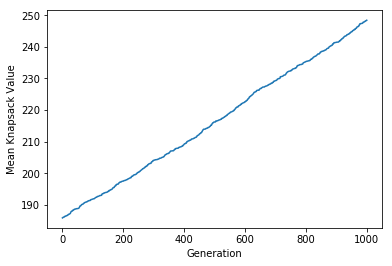

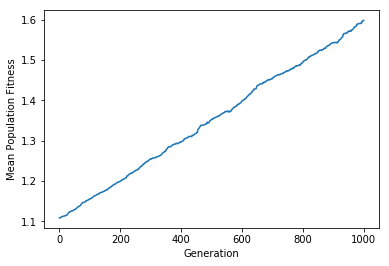

Best from tournament_selection is [244, 391, 167, 608, 386, 374, 580] whose weight is 200, value is 693 and fitness is 3.465


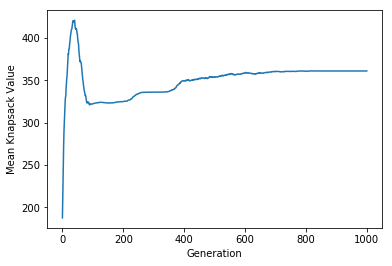

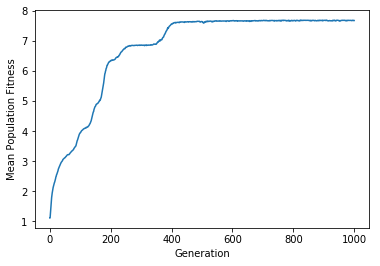

Best from random is [244, 391, 167, 608, 386, 374, 580] whose weight is 200, value is 693 and fitness is 3.465


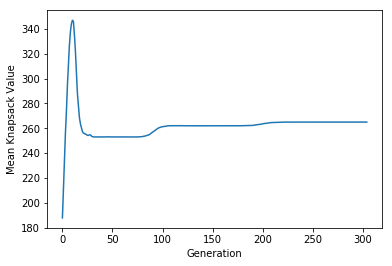

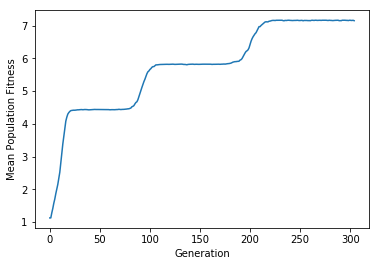

Best from proportional is [244, 391, 167, 608, 386, 374, 580] whose weight is 200, value is 693 and fitness is 3.465


In [7]:
best = run_knapsack_ga(itemset, max_weight, max_time)

In [8]:
print(get_genotype_weight(best))

200


In [9]:
for item in best:
    print(item, itemset[item].weight, itemset[item].value)

244 16 99
391 34 100
167 37 99
608 25 98
386 37 99
374 40 99
580 11 99
